Instrucciones
=============

1. Instalar ipython notebook
----------------------------

Ipython notebook es lo que usamos para crear y ejecutar estos "documentos con código" (notebooks). Lo instalamos usando pip:

    pip install "ipython[notebook]"
    
(con ``sudo`` antes, para los que están en linux y no están usando virtualenvs)


2. Instalar libs
----------------

Además vamos a estar usando varias libs útiles, que se instalan también con pip:

    pip install scikit-learn scipy pandas matplotlib keras theano h5py
    

3. Abrir este notebook
----------------------

Bajen el archivo ``tp_final.ipynb`` del repo, luego abran una consola, ingresen al directorio donde se encuentra el archivo, y ejecuten:

    ipython notebook
  
Esto les va a abrir una ventana del navegador web, donde pueden ver la lista de archivos del directorio, y entre esos archivos van a ver el notebook que se bajaron. Háganle click para abrirlo.

4. Uso del notebook
-------------------

La interfaz es bastante sencilla. Algunas cosas básicas que les pueden resultar útiles:

 * Para modificar el texto de una celda, háganle ``click`` o ``doble click``.

 * Para ejecutar una celda sola de forma rápida, usen ``shift+enter`` (en las de código, ejecuta el código, en las de texto, lo renderiza). 
 
 * Mientras el código se está ejecutando, al lado de la celda van a ver un ``[*]``. Eso significa que la celda aún se está ejecutando. Cuando ven un número (ej: ``[42]``), significa que ya terminó de ejecutarse (y el número es el orden en el cual esa celda fue ejecutada).
 
 * Pueden ejecutar todas las veces que quieran las celdas, en el orden que prefieran, etc. (pero claramente, para arrancar conviene ejecutar las celdas en orden)

Pueden experimentar con el resto de las cosas que ven en la interfaz :)
    
Consigna
========

Es un pájaro? Es un avión? No! Es el tp final de IA de este año: **clasificar pájaros vs aviones** utilizando **redes neuronales**.

En este trabajo práctico vamos a utilizar redes neuronales para intentar clasificar imágenes, determinando si el objeto que se ve en la imagen es un pájaro o un avión. 
Para ello, ya contamos con un set de 10.000 imágenes clasificadas en las que estamos seguros de lo que se ve: o un pájaro o un avión. 
Con estos datos entrenaremos una red neuronal, que luego deberá ser capaz de clasificar correctamente imágenes similares.

En clases vamos a ver cómo construir una red neuronal básica, y en este notebook ya tienen el código necesario para leer los datos, mostrar las imágenes, y evaluar la exactitud de la red.
El trabajo de ustedes consistirá en escribir el fragmento de código que construye y entrena la red neuronal, de forma tal que las métricas indiquen un 80% o más de accuracy en el conjunto de **test**.

Como el resultado no es el mismo si corren varias veces el código, lo que deben lograr es una red que en **al menos 3 de 5 ejecuciones**, logre 80% o más de accuracy.
No es válido entregar código que alguna vez tuvimos suerte y llegó al 80%, pero que habitualmente no lo alcanza.

La entrega se realizará subiendo el archivo ``tp_final.ipynb`` modificado por ustedes, a la **raiz** del repositorio del grupo.

Imports y configs
=================

In [1]:
# imports de libs que usamos para leer y procesar datos en masa
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning: separar conjuntos de datos, evaluar exactitud, etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# libs que usamos para construir y entrenar redes neuronales
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout, Convolution2D, MaxPooling2D, Flatten

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
# algunas configuraciones generales respecto a las imagenes
picture_size = 32
channels = 'rgb'

# nombres de las columnas de datos que vamos a usar como "entradas"
input_columns = []
for color in channels:
    input_columns.extend(['%s%i' % (color, i) 
                          for i in range(picture_size ** 2)])

Datos
=====

Leemos las 10.000 imagenes, que están guardadas en un solo archivo y mostramos 5 filas de ejemplo.

Cada fila es una imagen. Cada imagen tiene muchos pixeles. Y cada pixel tiene 3 valores: cuánto de rojo, cuánto de verde y cuánto de azul (estos son "canales" de color).

Eso quiere decir que si la imagen tiene 32 x 32 pixeles, y cada pixel tiene 3 valores, entonces tenemos 32 x 32 x 3 = 3072 columnas.

La última columna, 'label', es un 0 cuando la imagen contiene un pájaro, y 1 cuando contiene un avión.

In [3]:
data = pd.read_csv('data_tp_final.csv.gz')
data.sample(5)

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,label
7644,69,66,66,66,65,65,68,72,69,63,...,61,70,61,31,15,16,20,30,25,0
3062,249,248,249,249,249,249,248,248,248,247,...,96,83,50,33,34,60,64,52,57,1
9686,22,23,29,39,122,208,187,188,181,202,...,17,18,21,24,17,9,9,15,11,0
8881,218,204,198,206,194,216,223,198,202,216,...,101,102,102,101,101,101,100,99,99,0
4724,44,45,44,44,46,48,50,52,52,51,...,167,167,167,172,174,173,173,174,174,1


In [9]:
data.shape

(10000, 3073)

Estandarizamos los valores, para que vayan de 0 a 1. Esto puede demorar un rato. Al final mostramos la nueva tabla, estandarizada.

In [4]:
def standarize_inputs(dataset):
    dataset[input_columns] = dataset[input_columns].values / 255

In [5]:
standarize_inputs(data)

data.sample(5)

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,label
108,0.658824,0.647059,0.647059,0.647059,0.647059,0.647059,0.650980,0.650980,0.650980,0.650980,...,0.094118,0.086275,0.066667,0.074510,0.086275,0.098039,0.117647,0.113725,0.094118,1
3263,0.611765,0.607843,0.615686,0.607843,0.588235,0.572549,0.580392,0.576471,0.568627,0.564706,...,0.984314,0.984314,0.984314,0.980392,0.976471,0.976471,0.976471,0.980392,0.984314,1
3209,0.701961,0.709804,0.725490,0.713725,0.717647,0.698039,0.713725,0.733333,0.737255,0.713725,...,0.752941,0.741176,0.737255,0.741176,0.741176,0.745098,0.745098,0.741176,0.772549,1
7056,0.317647,0.337255,0.337255,0.294118,0.309804,0.368627,0.341176,0.309804,0.313725,0.298039,...,0.690196,0.729412,0.745098,0.792157,0.823529,0.839216,0.850980,0.862745,0.850980,0
721,0.666667,0.666667,0.674510,0.717647,0.760784,0.768627,0.741176,0.745098,0.760784,0.803922,...,0.490196,0.486275,0.482353,0.490196,0.486275,0.474510,0.466667,0.466667,0.474510,1


Esta función nos permite pasarle un conjunto de imagenes (filas de la tabla), y nos las dibuja. También admite usar alguna columna de la tabla como título para cada imagen

In [6]:
def show_images(samples, title=None):
    for index, sample in samples.iterrows():
        if title is not None:
            plt.title(str(sample[title]))

        sample_as_grid = sample[input_columns].values.reshape(len(channels), picture_size, picture_size)
        sample_as_grid = np.transpose(sample_as_grid, (1, 2, 0))
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

Mostramos algunas imagenes de ejemplo al azar. Pueden ustedes distinguir lo que hay en cada imagen? (si ejecutan esta celda muchas veces, van a ir viendo imágenes diferentes)

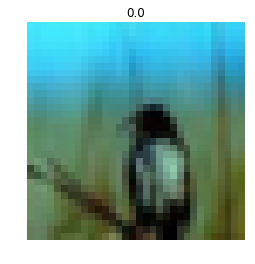

In [14]:
show_images(data.iloc[7644:7645], title='label')

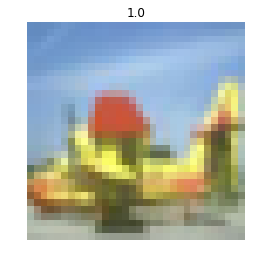

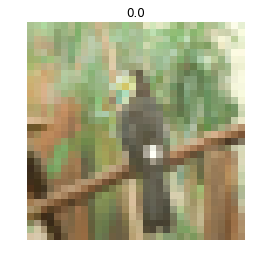

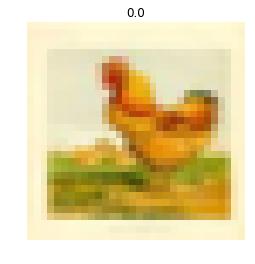

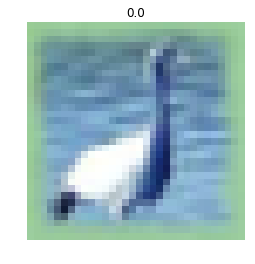

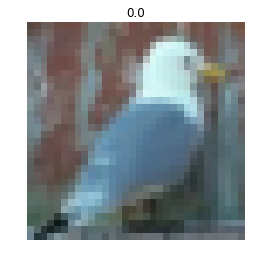

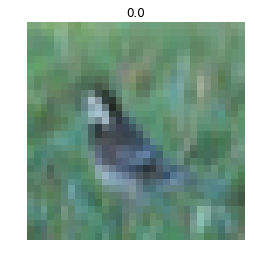

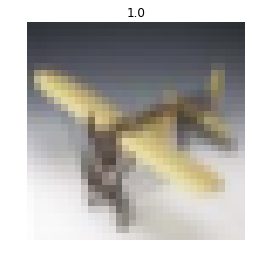

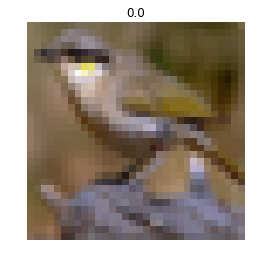

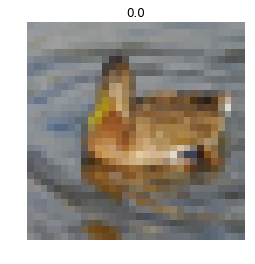

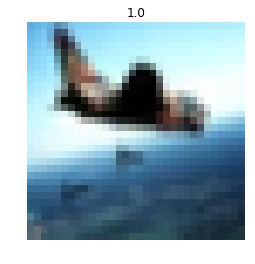

In [7]:
show_images(data.sample(10), title='label')

Y finalmente, separamos los datos en dos conjuntos, vamos a utilizar uno para entrenar la red y el otro para testearla (y de esa forma asegurarnos de que no estamos sobreentrenando, evaluar cómo se va a comportar con casos que no usó para entrenar, etc).

In [15]:
train, test = train_test_split(data, test_size=0.2)
sets = (
    ('train', train),
    ('test', test),
)

for set_name, set_data in sets:
    print('#' * 20, set_name, 'labels', '#' * 20)
    print(set_data.label.value_counts())
    print()

#################### train labels ####################
1    4040
0    3960
Name: label, dtype: int64

#################### test labels ####################
0    1040
1     960
Name: label, dtype: int64



Red neuronal
============

Esta primer función es una comodidad, para no tener que repetir este fragmento de código cada vez que queramos alimentar a la red neuronal con datos de entrada. Lo que hace la función, es quedarse solo con los valores de las columnas de entrada.

In [16]:
def extract_inputs(dataset):
    return dataset[input_columns].values.reshape(len(dataset), picture_size, picture_size, len(channels))

Y aquí es donde ustedes tienen que completar su entrega:

In [18]:
model = Sequential([
    Convolution2D(16, (4, 4), padding='valid', input_shape=(picture_size, picture_size, len(channels))),
    Activation('tanh'),
    Convolution2D(16, (4, 4)),
    Activation('tanh'),
    Convolution2D(16, (4, 4)),
    Activation('tanh'),
    Convolution2D(16, (4, 4)),
    Activation('tanh'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.1),
    Flatten(),

    Dense(200),
    Activation('tanh'),
    
    Dropout(0.1),
    
    Dense(200),
    Activation('tanh'),
    
    Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [19]:
model.fit(
    extract_inputs(train), 
    train.label.values, 
    epochs=5,
    batch_size=128,
)

Epoch 1/5
8000/8000 [==============================] - 9s - loss: 0.5221 - acc: 0.7343       

Una vez entrenada, pueden evaluar la performance de la red neuronal utilizando los dos conjuntos, con este fragmento de código.

El valor que tienen que lograr que llege a 80% (0.8) o más, es **accuracy** en el conjunto de **test**.

In [20]:
for set_name, set_data in sets:
    labels = set_data.label.values
    predicted_labels = np.rint(model.predict(extract_inputs(set_data)))

    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(labels, predicted_labels))
    print(classification_report(labels, predicted_labels))
    

######################### train #########################
accuracy 0.880375
             precision    recall  f1-score   support

          0       0.88      0.88      0.88      3960
          1       0.88      0.88      0.88      4040

avg / total       0.88      0.88      0.88      8000

######################### test #########################
accuracy 0.8625
             precision    recall  f1-score   support

          0       0.87      0.86      0.87      1040
          1       0.85      0.86      0.86       960

avg / total       0.86      0.86      0.86      2000



Finalmente, podemos clasificar todas las imágenes del conjunto de test, y mostrar algunos ejemplos de casos que anduvieron bien y casos que anduvieron mal.

El título en cada imagen es la salida de la red neuronal: más cerca de 1 significa avión, más cerca de 0 significa pájaro.

In [21]:
test_with_predictions = test.copy()
test_with_predictions['prediction'] = model.predict(extract_inputs(test_with_predictions))
test_with_predictions['predicted_label'] = np.rint(test_with_predictions.prediction)
is_correct = test_with_predictions.label == test_with_predictions.predicted_label

Bien clasificados:

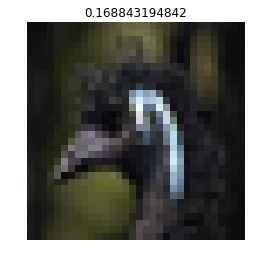

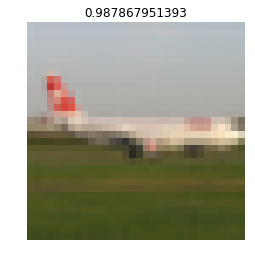

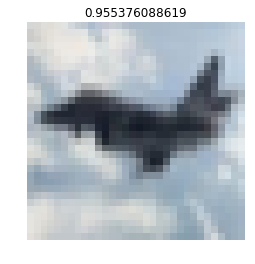

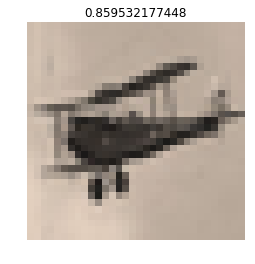

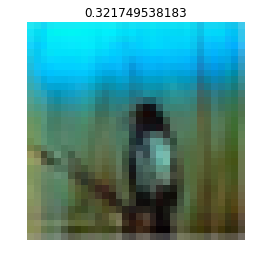

In [22]:
show_images(test_with_predictions[is_correct].sample(5), title='prediction')

Mal clasificados:

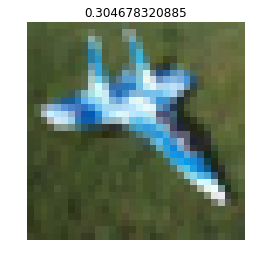

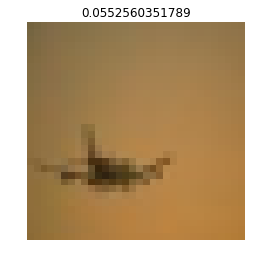

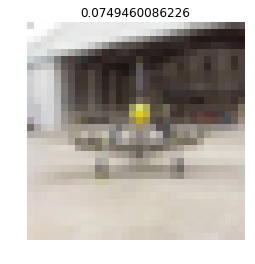

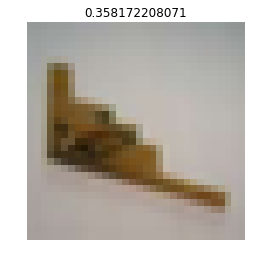

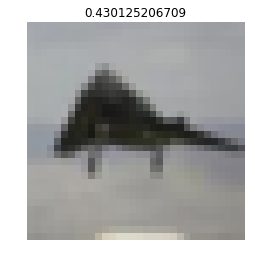

In [23]:
show_images(test_with_predictions[~is_correct].sample(5), title='prediction')

Y si quieren probar con otras imagenes que ustedes consigan, pueden usar esta otra función, pasándole una lista de paths de las imágenes en su disco. Pero **antes**, tienen que instalar otro paquete de python:

    pip install pillow
    
Esto es opcional, para que se diviertan, por eso no estaba al inicio en la consigna. Puede que renieguen para instalar pillow. En linux, puede que necesiten antes instalar otra cosa antes para que pillow se pueda instalar correctamente: ``sudo apt-get install libjpeg-dev``

In [24]:
from PIL import Image

def classify_pictures(pictures_paths):
    raw_pictures_data = []
    
    for picture_path in pictures_paths:
        picture = Image.open(picture_path)

        picture = picture.resize((picture_size, picture_size), Image.ANTIALIAS)
        picture_data = np.array(list(zip(*picture.getdata()))).reshape(len(input_columns))
    
        raw_pictures_data.append(picture_data)
    
    pictures_data = pd.DataFrame(raw_pictures_data, columns=input_columns)

    standarize_inputs(pictures_data)

    pictures_data['prediction'] = model.predict(extract_inputs(pictures_data))
    
    show_images(pictures_data, title='prediction')

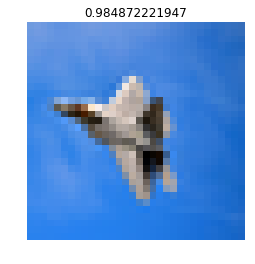

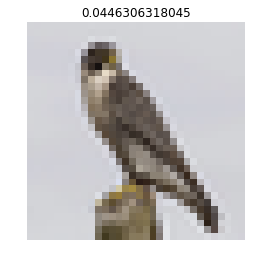

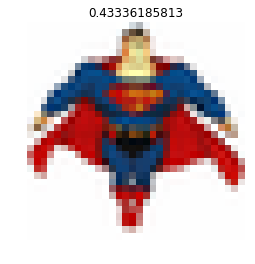

In [25]:
classify_pictures([
    '/home/fisa/Pictures/f22.jpg',
    '/home/fisa/Pictures/halcon.jpg',
    '/home/fisa/Pictures/superman.jpg',
    # etc...
])